In [1]:
import numpy as np
import scipy.optimize as optimize
import scipy as sc
import math as math
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Main 
"""
@ Params:
    R: a list of stock price
    k: number of latent components
@ Return:
    price_tplus1
    u_tplus1
    u_smooth
"""
def KalmanFilterForecast(R, k):
    r = 0.25*np.log(np.var(R,axis = 0,ddof=1))
    if k == 1:
        param0 = np.append(np.append(np.append(np.array(100),r,),100),r)
        
    if k == 2:
        param0 = np.append(np.append(np.append(np.array([100,100]),4*r),[-100,-100]),[r,r])
    def objective(params):
        Likelihood,_ = KalmanFilter(R,k,params)
        return Likelihood
    params_star = optimize.fmin(objective,param0)
    print(params_star)
    #params_star = optimize.minimize(objective,param0,method='CG')
    #params_star = params_star.values()[5]
    #print(params_star)
    u_smooth = KalmanSmoother(R, k, params_star)
#     Z = np.array(params_star[0])
#     H = np.exp(params_star[1]);
#     T = np.array(params_star[2])
#     Q = np.exp(params_star[3]);
    Z = 2/(1+np.exp(-params_star[0]))-1;
    H = np.exp(params_star[1]);
    T = 2/(1+np.exp(-params_star[2]))-1;
    Q = np.exp(params_star[3]);
      
    u_tplus1 = T*u_smooth[-1] + np.random.normal()*np.sqrt(Q)
    price_tplus1 = Z*u_tplus1 + np.random.normal()*np.sqrt(H)
    print('T*u_smooth[-1] is {}; Z*u_tplus1 is {}'.format(T*u_smooth[-1],Z*u_tplus1))
    return price_tplus1,u_tplus1,u_smooth,params_star

In [3]:
def KalmanFilter(R,k,params):
    S_length = R.shape[0]
    S = S_length+1
    if k == 1:
#         Z = np.array(params[0])
#         H = np.array(np.exp(params[1]))
#         T = np.array(params[2])
#         Q = np.array(np.exp(params[3]))
        Z = np.array(2/(1+np.exp(-params[0]))-1)
        H = np.array(np.exp(params[1]))
        T = np.array(2/(1+np.exp(-params[2]))-1)
        Q = np.array(np.exp(params[3]))
    if k == 2:
        Z = np.array([[2/(1+np.exp(-params[0]))-1,2/(1+np.exp(-params[1]))-1]])
        H = np.array(np.exp(params[2]))
        T = np.array([[2/(1+np.exp(-params[3]))-1,0],[0,2/(1+np.exp(-params[4]))-1]])
        Q = np.array([[np.exp(params[5]),0],[0,np.exp(params[6])]])
    u_predict = np.zeros((k,S));
    u_update = np.zeros((k,S));
    P_predict = np.zeros((k,k,S));
    P_update = np.zeros((k,k,S));
    v = np.zeros((1,S));
    F = np.zeros((1,S));
    KF_Dens = np.zeros((1,S));
    for i in range(S):
        if i == 0:
            P_update[:,:,i] = 1000*np.eye(k)
            P_predict[:,:,i] = T.dot(np.array(P_update[0][0][0]).dot(T.T))+Q
        else:
            F[0][i] = Z.dot(P_predict[:,:,i-1].dot(Z.T))+H
            v[0][i] = R.T.flatten()[i-1]-Z.dot(u_predict[:,i-1])
            u_update[:,i] = u_predict[:,i-1]+P_predict[:,:,i-1].dot(Z.T.dot(np.linalg.inv([[F[0][i]]]).dot(v[0][i]))).flatten()
            u_predict[:,i] = T.dot(u_update[:,i])
            P_update[:,:,i] = P_predict[:,:,i-1]-P_predict[:,:,i-1].dot(Z.T.dot(np.linalg.inv([[F[0][i]]]).dot(Z.dot(P_predict[:,:,i-1]))))
            P_predict[:,:,i] = T.dot(P_update[:,:,i]).dot(T.T)+Q
            KF_Dens[0][i] = (1.0/2)*np.log(2*np.pi)+(1.0/2)*np.log(np.abs(F[0][i]))+(1.0/2)+v[0][i].T*np.linalg.inv([[F[0][i]]])*v[0][i]
    Likelihood = np.sum(KF_Dens)-KF_Dens[0][0]
    varargout = [u_update, P_update, P_predict, T]
    return Likelihood, varargout

In [4]:
def KalmanSmoother(R,k,params_star):
    _,vararg = KalmanFilter(R,k,params_star)
    u_update = vararg[0]
    P_update = vararg[1]
    P_predict = vararg[2]
    T = np.array(vararg[3])
    S = R.shape[0]+1
    u_smooth = np.zeros((k,S))
    P_smooth = np.zeros((k,k,S))
    u_smooth[:,S-1] = u_update[:,S-1]
    P_smooth[:,:,S-1] = P_update[:,:,S-1]    
    for t in reversed(range(1,S)): # 2 to S inverse sequence
        u_smooth[:,t-1] = u_update[:,t] + P_update[:,:,t].dot(T.T.dot(np.linalg.inv(P_predict[:,:,t]).dot((u_smooth[:,t]-T.dot(u_update[:,t])))))
        P_smooth[:,:,t-1] = P_update[:,:,t] + P_update[:,:,t].dot(T.T).dot(np.linalg.inv(P_predict[:,:,t])).dot((P_smooth[:,:,t]-P_predict[:,:,t])).dot(np.linalg.inv(P_predict[:,:,t])).dot(T).dot(P_update[:,:,t])
    u_smooth = u_smooth.flatten()[1:]
    return u_smooth

In [10]:
data = pd.read_csv('NVDA.csv')
data=data.dropna()
R=data["Volume"].values
#R=np.matrix(R)
k=1
R

array([ 8951900., 12256800., 11233600., 16132600.,  9961800., 10234300.,
       11733900., 12041800., 15005900., 21036300., 11428500., 12029500.,
       12036400.,  6449900.,  6768200.,  5698600.,  5792500.,  6919400.,
        7762600.,  7247100.,  8547700.,  8169300.,  8703500., 15010700.,
       15221300., 10634300.,  8395000.,  8503600.,  8520400., 12133800.,
       19286700., 26716500., 13140700., 11241700.,  9234500.,  8421300.,
        8740400.,  9049100.,  8083600.,  8717500.,  5845300.,  7550100.,
        4382600.,  5999200.,  6873500.,  5569700.,  7152100.,  6935000.,
        4757800.,  5655400.,  9091100.,  8842000., 13637800.,  8444500.,
        6050300., 10725200.,  6123900.,  6634700.,  6545300.,  9417500.,
        9497100.,  8707300.,  9848500.,  8489200., 11334400.,  9452600.,
        6398400.,  9688100.,  7319100.,  8767900., 10414100., 10924300.,
        7683000.,  7728800.,  5004300.,  4457000.,  5588500.,  4799300.,
        5363400.,  8809900.,  9530600.,  8047600., 

In [11]:
price_tplus1,u_tplus1,u_smooth,params_star = KalmanFilterForecast(R, k)
#KalmanFilterForecast(R, k)

Optimization terminated successfully.
         Current function value: 15765.050545
         Iterations: 208
         Function evaluations: 368
[-417.68334334   31.06480284    3.97708318   31.2072884 ]
T*u_smooth[-1] is -9904307.622553626; Z*u_tplus1 is 15608885.517690804


In [12]:
print(price_tplus1)

11646927.018928336


In [13]:
print(u_tplus1)

-15608885.517690804


In [14]:
u_smooth=-u_smooth
print(u_smooth)

[10239263.55263235 11525816.48173165 13178402.66599641 11312796.52234523
 11080476.60354292 11876755.1561246  12860747.45142423 14843241.74344149
 16651863.38004627 13234917.24945099 11999179.91647777 10744006.10106275
  7956699.98273953  6984488.92932406  6281030.21426799  6283673.0095736
  6883169.55358077  7448964.42308147  7649748.30995866  8343325.49009994
  8803953.88677202 10036750.43730724 12879794.72212878 13189857.41650616
 11086449.18387131  9539925.31297863  9377491.56546969 10274442.97471242
 13285741.35994001 17694793.26282317 20222909.2904582  15005434.71779346
 12041473.62920699 10051908.67726213  9055056.33248065  8829650.47432193
  8723501.77642113  8239811.70982102  7954714.69701375  6767603.4895141
  6694167.70286093  5605432.40633541  5988527.14381143  6367260.07118487
  6148879.47374243  6632522.95046216  6503458.71043649  5866900.20278317
  6566381.0260491   8365699.44828251  9308337.5716023  10822347.39830855
  8980956.67147034  7794422.90572126  8706874.8731811

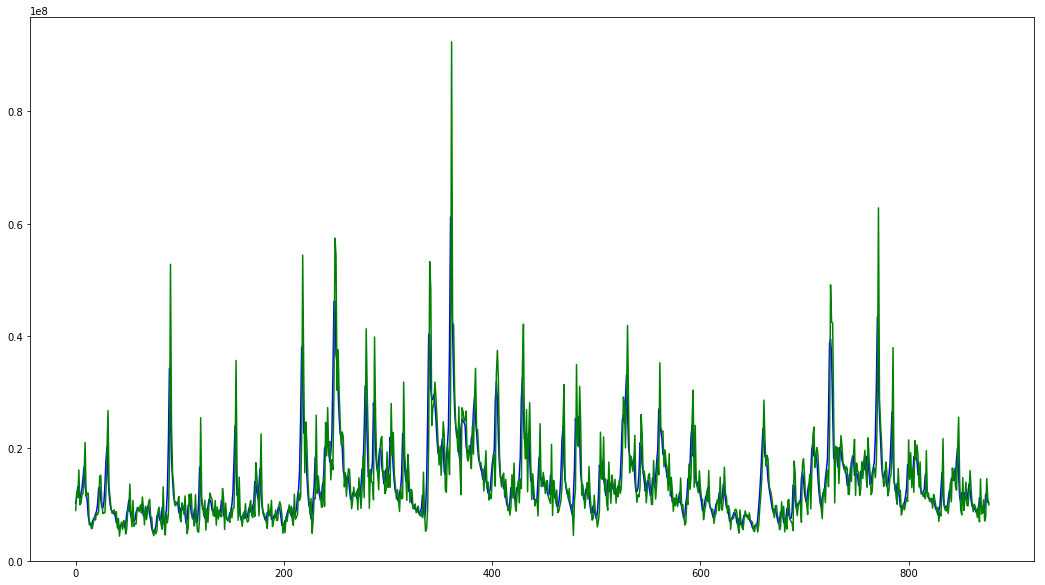

In [15]:
fig = plt.figure(figsize=(18,10))
#plt.plot(price_tplus1,'y',label = "price_tplus1")
#plt.plot(u_tplus1,'r',label = "u_tplus1")
plt.plot(u_smooth,'b',label = "u_smooth")
plt.plot(R,'g',label = "price")
plt.show()

In [16]:
params=np.matrix([[2.34],[3.24],[5.12],[6.34]])

In [17]:
KalmanFilter(R, k, params)

(92082659955347.98,
 [array([[0.00000000e+00, 1.06021714e+07, 1.46119274e+07, 1.36761418e+07,
          1.92155805e+07, 1.24915353e+07, 1.24118694e+07, 1.41195282e+07,
          1.45703504e+07, 1.79810531e+07, 2.50649850e+07, 1.45062372e+07,
          1.45787821e+07, 1.45908772e+07, 8.21274364e+06, 8.20547863e+06,
          6.98375437e+06, 7.01996324e+06, 8.30879666e+06, 9.34649775e+06,
          8.81819732e+06, 1.02725563e+07, 9.92501784e+06, 1.05147841e+07,
          1.77508164e+07, 1.84118584e+07, 1.32127025e+07, 1.03536161e+07,
          1.03114432e+07, 1.03281747e+07, 1.44550379e+07, 2.28622993e+07,
          3.18345188e+07, 1.68547382e+07, 1.38157475e+07, 1.13472330e+07,
          1.02752215e+07, 1.05772722e+07, 1.09473111e+07, 9.86638103e+06,
          1.05273617e+07, 7.28621334e+06, 9.04442420e+06, 5.52986649e+06,
          7.17147680e+06, 8.26519291e+06, 6.84004312e+06, 8.56404333e+06,
          8.41635420e+06, 5.92177666e+06, 6.80169403e+06, 1.07758239e+07,
          1.072237

In [18]:
params_star = [2.34,3.41,4.12,5.22]

In [19]:
u_smooth=KalmanSmoother(R, k, params_star)
u_smooth

array([14203844.13489344, 14366710.6295523 , 17710672.21523263,
       13090948.41332786, 12796804.19211474, 14148613.29560841,
       15142867.78376641, 18442666.43743799, 22781085.61431793,
       15392635.787614  , 14572179.3475332 , 13673151.94565685,
        8803047.75015806,  8136942.81027837,  7161293.56320357,
        7255946.15396242,  8338374.09240922,  9188652.89580753,
        9067089.80466179, 10134361.12052091, 10201761.28870472,
       11527239.49780998, 17017321.05845392, 17406669.76546682,
       13269741.21766265, 10726344.61735136, 10517039.25775908,
       11178910.01287706, 15463808.04499112, 22952327.57618925,
       28551750.79268709, 17624890.62164783, 13933250.1677941 ,
       11521122.31371383, 10484558.06586513, 10608041.41661218,
       10761004.75172441,  9993453.60258977, 10036290.06763153,
        7775083.66767593,  8453905.12059736,  6114638.27789194,
        7202942.85728132,  7976189.50271251,  7202422.93674046,
        8346061.08694044,  8079784.87868

In [20]:
import matplotlib.pyplot as plt

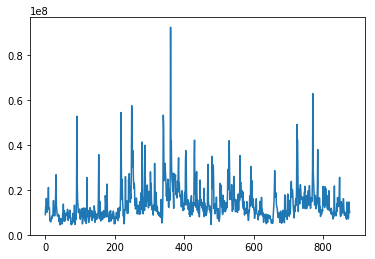

In [21]:
plt.plot(R)
plt.show()

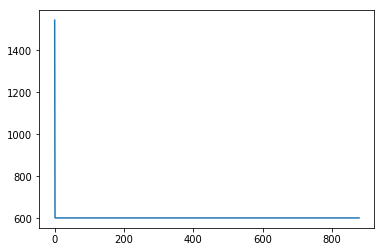

In [22]:
_, varargout = KalmanFilter(R, k, params)
u_update, P_update, P_predict, T = varargout
P_predict = np.squeeze(np.asarray(P_predict))
plt.plot(P_predict)
plt.show()

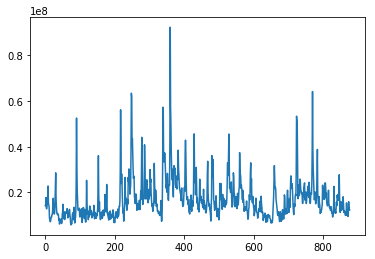

In [23]:
plt.plot(u_smooth)
plt.show()